In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel as C



In [2]:
# Load data
df = pd.read_csv('kc_house_data.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset to inspect its structure
print(df.head())

             id             date     price  bedrooms  bathrooms  sqft_living  \
0  7.129301e+09  20141013T000000  221900.0       3.0       1.00       1180.0   
1  6.414100e+09  20141209T000000  538000.0       3.0       2.25       2570.0   
2  5.631500e+09  20150225T000000  180000.0       2.0       1.00        770.0   
3  2.487201e+09  20141209T000000  604000.0       4.0       3.00       1960.0   
4  1.954401e+09  20150218T000000  510000.0       3.0       2.00       1680.0   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0    5650.0     1.0         0.0   0.0  ...    7.0      1180.0            0.0   
1    7242.0     2.0         0.0   0.0  ...    7.0      2170.0          400.0   
2   10000.0     1.0         0.0   0.0  ...    6.0       770.0            0.0   
3    5000.0     1.0         0.0   0.0  ...    7.0      1050.0          910.0   
4    8080.0     1.0         0.0   0.0  ...    8.0      1680.0            0.0   

   yr_built  yr_renovated  zipcode    

In [3]:
# Check for missing values
print(df.isna().sum())


id               20613
date             20613
price            20613
bedrooms         20613
bathrooms        20613
sqft_living      20613
sqft_lot         20613
floors           20613
waterfront       20613
view             20613
condition        20613
grade            20613
sqft_above       20613
sqft_basement    20613
yr_built         20613
yr_renovated     20613
zipcode          20613
lat              20613
long             20613
sqft_living15    20613
sqft_lot15       20613
dtype: int64


In [4]:
# Feature engineering
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['id', 'date'], axis=1)

# Drop rows where the target variable 'price' is NaN
df = df.dropna(subset=['price'])

# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Impute missing values in features
imputer_X = SimpleImputer(strategy='mean')
X = imputer_X.fit_transform(X)

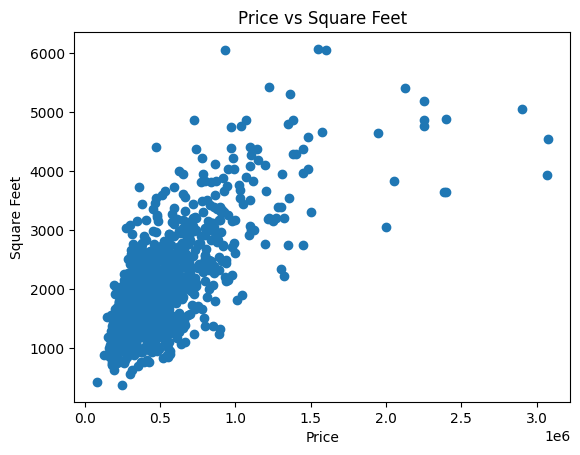

In [5]:
# Distribution of Bedrooms visualization
plt.scatter(df['price'], df['sqft_living'])
plt.title('Price vs Square Feet')
plt.xlabel('Price')
plt.ylabel('Square Feet')
plt.show()

<Figure size 600x600 with 0 Axes>

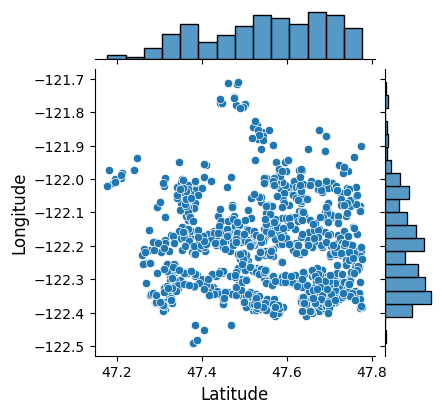

In [6]:
# Data Geospatial Analysis visualization
plt.figure(figsize=(6, 6))
sns.jointplot(x=df['lat'].values, y=df['long'].values, height=4)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

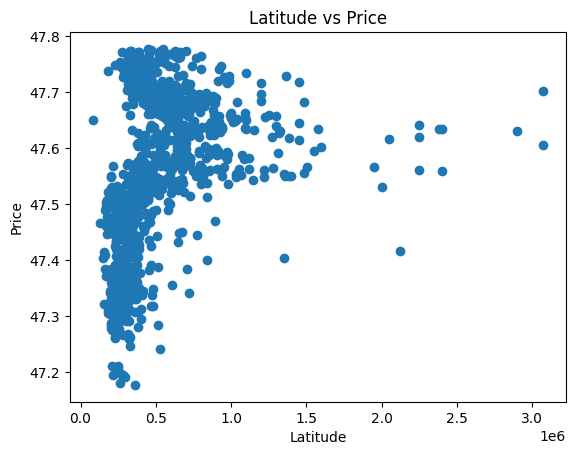

In [7]:
# Scatter plot of price vs latitude: Plots a scatter plot where each point represents a pair of values from the price and lat columns in the DataFrame df.
plt.scatter(df['price'], df['lat'])
plt.title('Latitude vs Price')
plt.xlabel('Latitude')
plt.ylabel('Price')
plt.show()

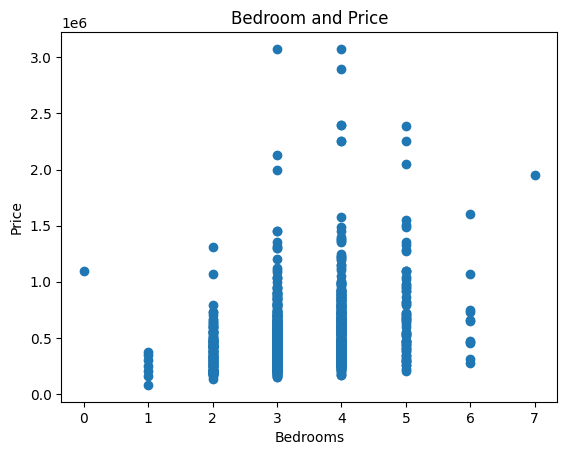

In [8]:
# Bedroom price distribution
plt.scatter(df['bedrooms'], df['price'])
plt.title('Bedroom and Price')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

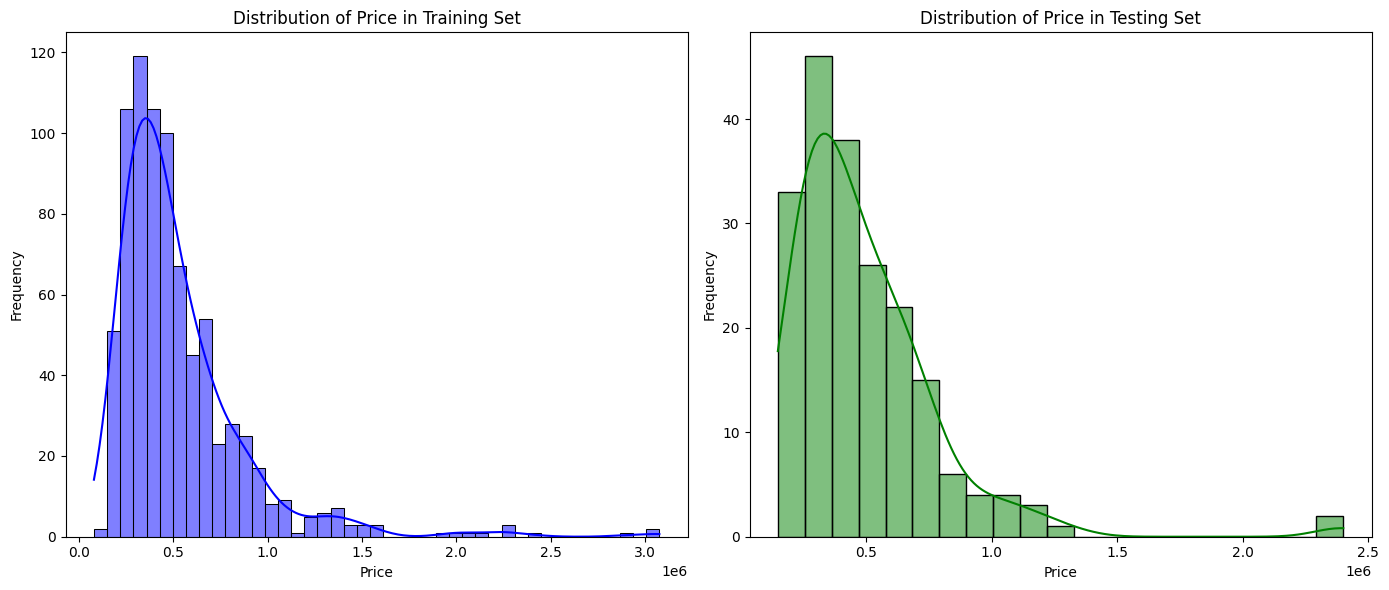

In [10]:
# Plot the distribution of price in the training set
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, color='blue')
plt.title('Distribution of Price in Training Set')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Plot the distribution of price in the testing set
plt.subplot(1, 2, 2)
sns.histplot(y_test, kde=True, color='green')
plt.title('Distribution of Price in Testing Set')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Hyperparameter tuning for Gaussian Process Regressor with RationalQuadratic Kernel
alphas = [1e-2, 1e-1, 1e-3]
length_scales = [0.5, 1.0, 2.0]
best_mse = float('inf')
best_params = None
for alpha in alphas:
    for length_scale in length_scales:
        kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=length_scale, alpha=1.0)
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=alpha)
        gpr.fit(X_train, y_train)
        y_pred, y_std = gpr.predict(X_test, return_std=True)
        mse = mean_squared_error(y_test, y_pred)
        if mse < best_mse:
            best_mse = mse
            best_params = (alpha, length_scale)
print(f'Best MSE: {best_mse}')
print(f'Best Parameters: alpha={best_params[0]}, length_scale={best_params[1]}')


Best MSE: 25581393175.974995
Best Parameters: alpha=0.1, length_scale=2.0


In [12]:
from sklearn.model_selection import train_test_split, cross_val_score

# Implementing Cross-Validation
kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=best_params[1], alpha=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=best_params[0])
cv_scores = cross_val_score(gpr, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print(f'Cross-Validation MSE: {cv_mse}')


Cross-Validation MSE: 80521859968.61261


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Comparing with Baseline Models
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)

print(f'Linear Regression MSE: {mse_lr}')
print(f'Decision Tree MSE: {mse_dt}')

Linear Regression MSE: 30408655051.880894
Decision Tree MSE: 29466919542.43


In [31]:
# Feature Engineering: Adding polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Re-training the best GPR model with polynomial features
gpr_poly = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=best_params[0])
gpr_poly.fit(X_train_poly, y_train)
y_pred_poly, y_std_poly = gpr_poly.predict(X_test_poly, return_std=True)
mse_poly = mean_squared_error(y_test, y_pred_poly)
print(f'Mean Squared Error with Polynomial Features: {mse_poly}')

KeyError: 0

                          Model           MSE  Cross-Validation MSE
0             Linear Regression  3.040866e+10                   NaN
1                 Decision Tree  2.946692e+10                   NaN
2             GPR (Best Kernel)  2.558139e+10          8.052186e+10
3  GPR with Polynomial Features  3.564591e+10                   NaN


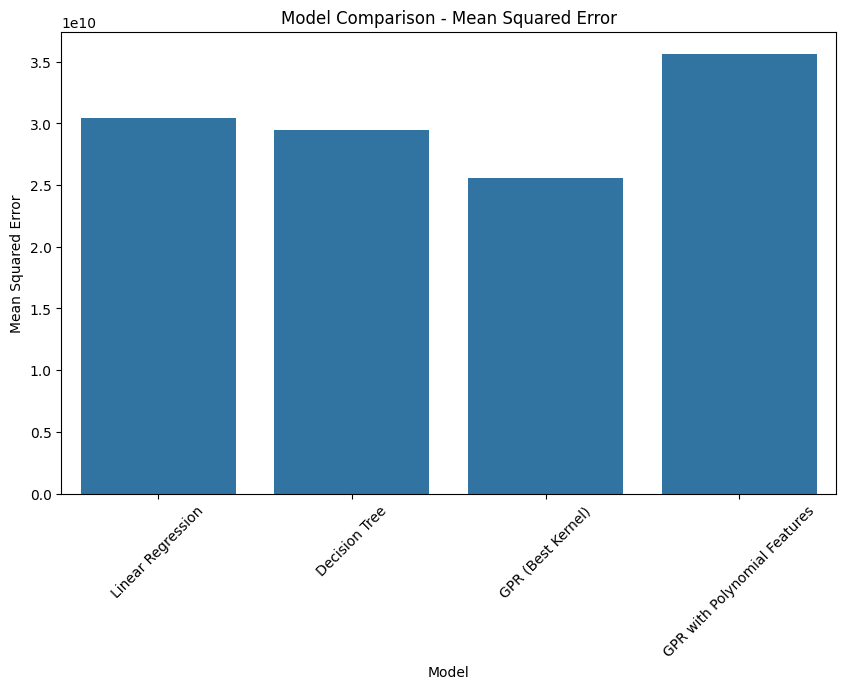

In [16]:
# Creating a DataFrame to display results
results = {
    'Model': ['Linear Regression', 'Decision Tree', 'GPR (Best Kernel)', 'GPR with Polynomial Features'],
    'MSE': [mse_lr, mse_dt, best_mse, mse_poly],
    'Cross-Validation MSE': [None, None, cv_mse, None]  # Only GPR (Best Kernel) includes CV
}
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('Model Comparison - Mean Squared Error')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()


In [18]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Define models and parameter grids
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'GPR': GaussianProcessRegressor()
}

param_grids = {
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'GPR': {
        'alpha': [1e-10, 1e-5, 1e-2, 1, 10],
        'kernel': [1.0 * RBF(length_scale=1.0), 1.0 * RationalQuadratic(alpha=0.1, length_scale=1.0)]
    }
}


In [19]:
# Perform hyperparameter tuning and cross-validation
tuned_results = {}

for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    cv_mse = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    
    tuned_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_cv_mse': cv_mse,
        'best_model': best_model
    }


In [20]:
# Feature Engineering with Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


In [21]:
# Train models on polynomial features
models_poly = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'GPR': GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0))
}

poly_results = {}

for model_name, model in models_poly.items():
    model.fit(X_train_poly, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test_poly))
    cv_mse = -cross_val_score(model, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    
    poly_results[model_name] = {
        'mse': mse,
        'cv_mse': cv_mse,
        'model': model
    }

# Compile results
all_results = {
    'Model': [],
    'MSE': [],
    'Cross-Validation MSE': [],
    'Best Parameters': []
}

# Add tuned models results
for model_name, results in tuned_results.items():
    all_results['Model'].append(f"{model_name} (Tuned)")
    all_results['MSE'].append(mean_squared_error(y_test, results['best_model'].predict(X_test)))
    all_results['Cross-Validation MSE'].append(results['best_cv_mse'])
    all_results['Best Parameters'].append(results['best_params'])

# Add polynomial models results
for model_name, results in poly_results.items():
    all_results['Model'].append(f"{model_name} with Polynomial Features")
    all_results['MSE'].append(results['mse'])
    all_results['Cross-Validation MSE'].append(results['cv_mse'])
    all_results['Best Parameters'].append(None)

# Create DataFrame
results_df = pd.DataFrame(all_results)

# Display results
print(results_df)


                                        Model           MSE  \
0                       Decision Tree (Tuned)  2.666925e+10   
1                                 GPR (Tuned)  2.558139e+10   
2  Linear Regression with Polynomial Features  3.814196e+10   
3      Decision Tree with Polynomial Features  4.502863e+10   
4                GPR with Polynomial Features  3.292951e+11   

   Cross-Validation MSE                                    Best Parameters  
0          4.640772e+10          {'max_depth': 5, 'min_samples_split': 10}  
1          3.829503e+10  {'alpha': 10, 'kernel': 1**2 * RationalQuadrat...  
2          3.727779e+35                                               None  
3          5.411634e+10                                               None  
4          4.002511e+11                                               None  


In [22]:
# Add tuned models results
for model_name, results in tuned_results.items():
    all_results['Model'].append(f"{model_name} (Tuned)")
    all_results['MSE'].append(mean_squared_error(y_test, results['best_model'].predict(X_test)))
    all_results['Cross-Validation MSE'].append(results['best_cv_mse'])
    all_results['Best Parameters'].append(results['best_params'])

# Add polynomial models results
for model_name, results in poly_results.items():
    all_results['Model'].append(f"{model_name} with Polynomial Features")
    all_results['MSE'].append(results['mse'])
    all_results['Cross-Validation MSE'].append(results['cv_mse'])
    all_results['Best Parameters'].append(None)

# Create DataFrame
results_df = pd.DataFrame(all_results)

# Display results
print(results_df)

                                        Model           MSE  \
0                       Decision Tree (Tuned)  2.666925e+10   
1                                 GPR (Tuned)  2.558139e+10   
2  Linear Regression with Polynomial Features  3.814196e+10   
3      Decision Tree with Polynomial Features  4.502863e+10   
4                GPR with Polynomial Features  3.292951e+11   
5                       Decision Tree (Tuned)  2.666925e+10   
6                                 GPR (Tuned)  2.558139e+10   
7  Linear Regression with Polynomial Features  3.814196e+10   
8      Decision Tree with Polynomial Features  4.502863e+10   
9                GPR with Polynomial Features  3.292951e+11   

   Cross-Validation MSE                                    Best Parameters  
0          4.640772e+10          {'max_depth': 5, 'min_samples_split': 10}  
1          3.829503e+10  {'alpha': 10, 'kernel': 1**2 * RationalQuadrat...  
2          3.727779e+35                                               None 

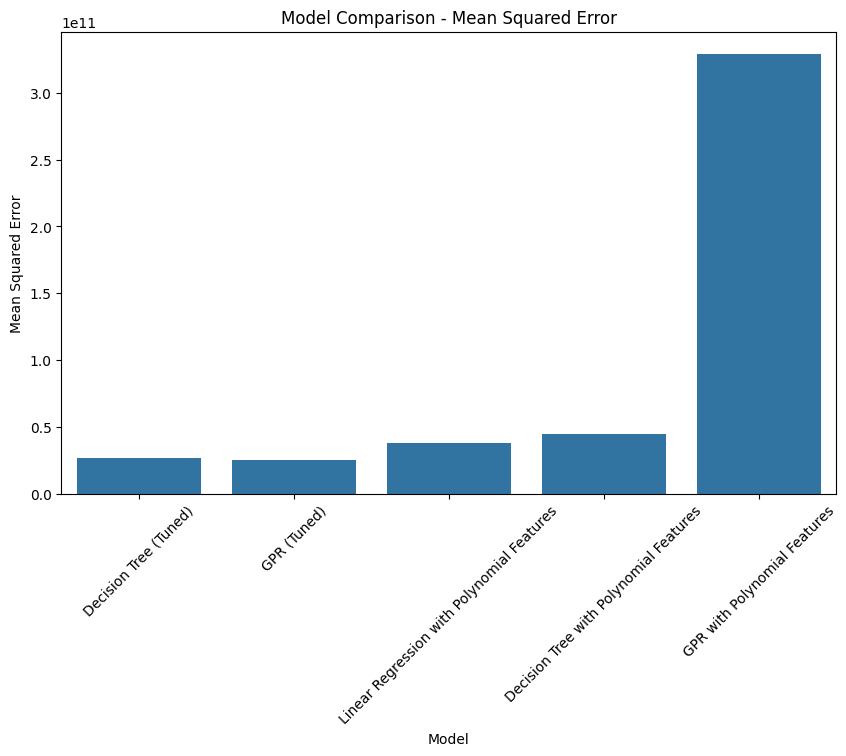

In [23]:
# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MSE', data=results_df)
plt.title('Model Comparison - Mean Squared Error')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()

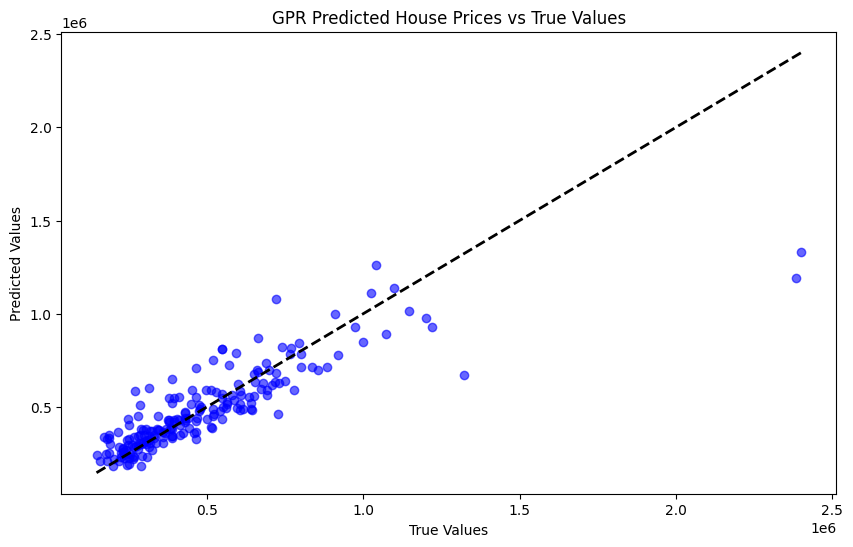

In [30]:
# Best parameters from hyperparameter tuning (use your best parameters here)
best_params = {'alpha': 0.1, 'length_scale': 2.0}

# Define the best GPR model based on the parameters obtained
best_gpr_kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=best_params['length_scale'], alpha=1.0)
best_gpr_model = GaussianProcessRegressor(kernel=best_gpr_kernel, n_restarts_optimizer=10, alpha=best_params['alpha'])

# Train the best GPR model on the training data
best_gpr_model.fit(X_train, y_train)

# Predict house prices on the test set
y_pred_gpr = best_gpr_model.predict(X_test)

# Plotting the true values versus predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gpr, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GPR Predicted House Prices vs True Values')
plt.show()